# TDO-Objekte nach Haberlie et al. (2015)

Dies ist eine Pythonimplementierung des Algorithmus, der in Haberlie et al. (2015) vorgestellt wird, und dessen Ziel es ist, neu enstehende konvektive Bereiche zu finden.

Das Grundidee des Algorithmus besteht darin, möglichst langlebige neu entstehende konvektiv aktive Bereiche in einem Stapel mit Wetterradardaten zu erkennen. Die Trennung zwischen konvektiv aktiven und inaktiven Bereichen erfolgt über einen Schwellwert, z.B. Z > 35 dBZ. Das heißt alle Bereiche mit einer Reflektivtät über diesem Schwellwert werden zumindest theoretisch als konvektiv aktiver Bereich betrachtet. Die Trennung von neu entstehenden und schon länger aktiven konvektiven Bereichen erfolgt über eine Abstandspufferung mit einem gegebenen Pufferabstand um bereits länger aktive Bereiche. Alle neu auftauchenden Pixel deren Radarreflektivitätsfaktor über dem Schwellwert liegt und die außerhalb des Puffers liegen werden als neue konvektiv aktive Objekte betrachtet. Diese neuen konvektiv aktiven Objekte werden dann per Overlap-Tracking über eine gegebene Anzahl von Zeitschritten (im Original 7) verfolgt. Wenn sie nach der gegebene Zeit noch aktiv sind, werden sie als tatsächlich konvektiv aktive "Time-Domain-Objects" (TDO) gespeichert. 

Zunächst müssen einige nötige Pakete eingebunden werden. Diese Implementierung benötigt numpy, scipy, scikit-image, matplotlib und copy.

In [27]:
%matplotlib inline
import numpy as np

from scipy import ndimage as ndi
from skimage import morphology 

import copy

import matplotlib.pyplot as plt

Dann müssen Wetterradardaten geladen werden, die idealerweise schon mit einem Radarschwellwert vormaskiert sind. Für dieses Beispiel, laden wir RADOLAN-Daten für den 28.07.2012 11:00 bis 11:30. Wir laden also die Radatdaten für sieben aufeinander folgende Zeitschritte. Dazu müssen wir weitere Pakete einbinden:

In [2]:
from io_tools import radolan as rado
import datetime

Dann erstellen wir eine Liste mit den nötigen Zeitschitten.

In [16]:
start_time = datetime.datetime(2012,7,28,11,0)
end_time = datetime.datetime(2012,7,28,11,35)

time_list = []
    
while start_time <= end_time:
    time_list.append(start_time)
    start_time += datetime.timedelta(minutes=5)

Nun laden wir die Radardaten und maskieren sie mit einem Schwellwert von Z = 35 dBZ.

In [17]:
radar_threshold = 35
rado_stack = []

for t in time_list:
    r = rado.Radolan()
    r.read(t,rproduct='rx_hdcp2')
    Z = r.data
    Zm = np.ma.masked_where(Z < radar_threshold,Z)

    rado_stack.append(Zm)

Der nächste Schritt ist, die Pufferung des ersten Zeitschrittes der maskierten Daten. Als Pufferradius nehmen wir hier 15 km.

In [20]:
buffer_radius = 15

kernel = morphology.disk(buffer_radius)
binary_field = ~rado_stack[0].mask * 1

buffered_t0 = ndi.morphology.binary_dilation(binary_field==1,structure=kernel)

Nun suchen wir die wirklich neuen konvektiv aktiven Pixel im nächsten Zeitschritt. Dazu suchen wir erstmal alle Pixel heraus, die interessant sein könnten:

In [21]:
convectively_active_pixels_t1 = ~rado_stack[1].mask * 1

Dann überprüfen wir, welche Pixel außerhalb der Puffer des ersten Zeitschrittes liegen.

In [23]:
buffer_check = buffered_t0 + convectively_active_pixels_t1*3 

Jetzt sollten alle tatsächlich neu hinzugekommenen Pixel, die nicht innerhalb der Puffer liegen den Wert 3 haben, während die Pufferpixel = 1 sind und die in den Puffern liegenden neuen Pixel den Wert vier haben. Um die interessanten neuen Pixel von den anderen zu trennen, wird alles dessen Wert nicht gleich drei ist auf null gesetzt und dann die ganze Matrix durch drei geteilt. Nun sollten nur noch die interessanten Pixel vorhanden sein und den Wert eins haben.

In [24]:
convective_initiation_t1 = buffer_check.copy() 
    
convective_initiation_t1[np.where(convective_initiation_t1!=3)] = 0
convective_initiation_t1 = convective_initiation_t1 / 3 

Darstellung, um visuell zu überprüfen, ob wir neue interessante Pixel haben:

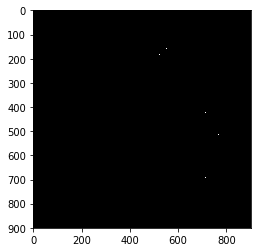

In [29]:
plt.imshow(convective_initiation_t1,cmap='gray',interpolation='none')

Es gibt tatsächlich Bereiche, die interessant sein könnten.

Nun wird aus dieser Ebene und den nächsten Zeitschritten ein Stapel gebildet.

In [42]:
analysis_stack = [convective_initiation_t1]
   
for i in xrange(2,len(time_list)):
        analysis_stack.append(~rado_stack[i].mask*1)

Auf diesen Stapel wird jetzt dreidimensionales Connected-Component-Labeling mit einer 26er Nachbarschaft durchgeführt, um die interessanten Pixel zu verfolgen.

In [34]:
 clustered, clusternumber = ndi.measurements.label(analysis_stack, structure=morphology.cube(3))

Dabei ergeben sich in allen Zeitschritten neue Objekte. Uns interessieren aber nur die aus dem ersten Zeitschritt unseres Stapels. Deshalb extrahieren wir deren Bezeichnung und ihre Pixelanzahl.

In [36]:
labels, counts = np.unique(clustered[0],return_counts=True) 
print labels,counts

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [809949      1      1      2      1      1      3     20      1      7
      1      1      1      8      2      1]


In diesem Fall gibt es im ersten Zeitschritt 15 verschieden Objekte. Davon bezeichnet 0 denn Hintergrund. Die meisten Objekte sind ziemlich klein, aber es gibt auch ein paar größere. Das können neue Objekte sein, aber auch welche, die in den vom Radarnetzwerk abgedeckten Bereich hinengewandert sind.

Da wir nun die Bezeichnung aller interessanten Objekte aus dem ersten Zeitschritt kennen, können wir alle Objekte, die sich danach entwickelten, entfernen.

In [37]:
convective_clusters = copy.deepcopy(clustered)

for i in xrange(1,len(convective_clusters)):
    convective_clusters[i][np.where(convective_clusters[i]>np.max(labels))] = 0

Nun können wir kontrollieren, welche Objekte, die im ersten Zeitschritt enstanden sind, noch bis zum letzten überdauert haben.

In [41]:
convective_index = np.unique(convective_clusters[-1])
convective_index_list = convective_index.tolist()
convective_index_list.remove(0) # remove background

print(convective_index_list)

[6, 7, 13]


In diesem Fall sind es drei Objekte.

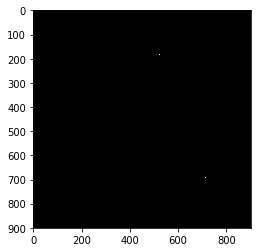

In [52]:
objekte_t1 = copy.deepcopy(clustered[0])

objekte_t1[np.where(objekte_t1<6)] = 0
objekte_t1[np.where(np.logical_and(objekte_t1>7,objekte_t1<13))] = 0
objekte_t1[np.where(objekte_t1>13)] = 0
objekte_t1[np.where(objekte_t1!=0)] = 1

plt.imshow(objekte_t1,cmap="gray",interpolation='none')